In [118]:
#IN google colab install abtem and pycu for gpu acceleration:
#!pip install abtem
#!pip install pycu

from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell

from ase.lattice.cubic import Diamond

from ase.spacegroup import crystal

from ase.visualize import view

from abtem.aperture import BullseyeAperture

from ase.build import graphene_nanoribbon

from ase.build import rotate

from ase.cluster.cubic import FaceCenteredCubic

from ase.build import nanotube
from ase import Atoms

import ase

from ase.build.attach import attach

current version: 1.0.0beta25


# STEM simulation of nanoparticle on graphen nanoribbon

In [119]:
gnr = graphene_nanoribbon(16, 12, type='zigzag', saturated=False, vacuum=0)
gnr.rotate(-90, 'x', rotate_cell=True)
gnr.center(about=(0,0,0))
view(gnr)


#cnt1 = nanotube(6, 4, length=1)
#cnt.rotate(-90, 'x', rotate_cell=True)
#cnt.center(vacuum=5, axis=(0,1))
#rotate(cnt1,(0,0,1),(0,1,0),(1,0,0),(1,0,0))
#view(cnt1)
#atoms=cnt1



surfaces = [(1, 1, 1), (0, 1, 0), (0, 0, 1)]
layers = [4, 5, -1]

nano = FaceCenteredCubic('Ag', surfaces, layers, vacuum=0) #be careful abtem.lattice.FaceCenterCubic is not abtem.cluster.FaceCenterCubic which you need
#nano.center()
nano.rotate(180,'x',rotate_cell=True,center='COM')
nano.center(about=(0,0,5))

#atoms =Atoms(atoms, positions=[(1., 0., 0.)], cell=[40, 40, 40])
view(nano)

atoms = ase.build.attach.attach(nano,gnr,distance=2,direction=(0,0,-1))
atoms = ase.Atoms(atoms,cell=[32,32,12]) #so that Pitential will be able to see z dimensions in Cells of atoms object
atoms.center()
view(atoms)

In [120]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([32.0, 32.0, 12.0])


We create and calculate the electrostatic potential.

In [230]:
potential = Potential(atoms, 
                      gpts=512,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

potential = potential.build()

12

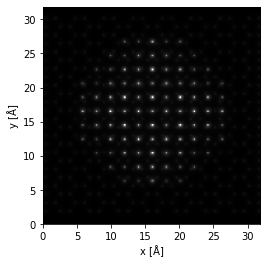

In [196]:
potential.project().show()
len(potential)

To simulate temperature effects uncomment the code below.

In [197]:
#sigmas = {'Mo': .1, 'S': .1} # standard deviations of thermal vibrations
#num_configs = 30 # number of frozen phonon configurations

#frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)
#potential = Potential(frozen_phonons, gpts=512, slice_thickness=1, parametrization='kirkland', projection='infinite')

In [198]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.125, 0.125)


In [383]:
#aperture = BullseyeAperture(outer_angle = 18,inner_angle=0)
aperture = BullseyeAperture(outer_angle = 17,inner_angle=16,energy=80e3)
#aperture = BullseyeAperture(outer_angle = 8,inner_angle=7)

We create a probe with a semi-angle cutoff of 20 mrad.

In [384]:
#probe = Probe(aperture = aperture, energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)

In [385]:
#probe = Probe(aperture = aperture, energy=80e3, semiangle_cutoff=12, rolloff=0.1, defocus=480, Cs=3e6)

To run this simulation using PRISM instead of the standard multislice algorithm, uncomment the cell below. Note that while PRISM may be up to a 1000 times faster than multislice for large structures, the performance is fairly similar for small simulations like this.

In [386]:
probe = SMatrix(aperture = aperture, energy=80e3, semiangle_cutoff=12, expansion_cutoff=20, rolloff=0.1, defocus=480, Cs=3e6)

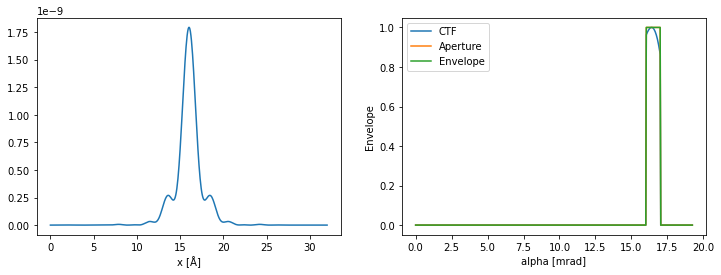

In [387]:
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

probe.profile().show(ax=ax1);

probe.ctf.show(ax=ax2);

We create a `FlexibleAnnularDetector` detector which will allow us to choose the integration limits after the multislice simulation.

In [243]:
detector = FlexibleAnnularDetector()

We scan over one periodic unit of the potential at slightly better than the Nyquist frequency of the probe contrast transfer function.

In [244]:
end = (potential.extent[0], potential.extent[1])

gridscan = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, potential)

Scan:   0%|          | 0/1681 [00:00<?, ?it/s]

The output from the simulation is a `Measurement` object. This wraps a numpy array with calibrations descibing each axis. 

In our case, the first two dimensions of the numpy array scan dimenstions and the last dimension are the bins of the detector.

In [245]:
sampling=probe.ctf.nyquist_sampling * .9
print(end[0] / sampling)

40.87123366576573


In [246]:
print(end[1] / sampling)

40.87123366576573


In [247]:
measurement.array.shape

(41, 41, 222)

We reduce the measurement to an image by integrating over the detector dimension.

In [248]:
measurement.integrate(0, 20).array.shape

(41, 41)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f0d5fd06520>)

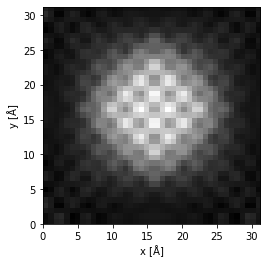

In [249]:
measurement.integrate(20, 40).show()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f0d2ee3b3a0>)

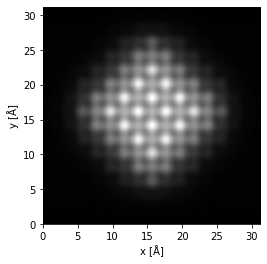

In [210]:
measurement.integrate(20, 40).interpolate(0.05).show()

In [250]:
measurement.integrate(20, 40).interpolate(0.05).show()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f0d5fc67610>)